# Import Libraries, Load Data

### Imports

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime

### Setting up Data

In [2]:
# # Paths:
#price_path = "/Users/amilamuthunayake/Documents/Trading_Research/correlation_matrix_spectral_clustering/get_shardar_all_equity_based_on_cap/price_data_from_shardar.csv"
#cap_path = "/Users/amilamuthunayake/Documents/Trading_Research/correlation_matrix_spectral_clustering/get_shardar_all_equity_based_on_cap/cap_data_from_shardar.csv"
#price_path = "C:/Users/Owner/school/math4920/price_data_from_shardar.csv"
#cap_path = "C:/Users/Owner/school/math4920/cap_data_from_shardar.csv"

#ETF Path
ETF_Path = "/Users/tuckeringlefield/Desktop/EFT_Data/ETF_prices.csv"

# Reading Data:
#prices_df = pd.read_csv(price_path, index_col='date')
#caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
#prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
#caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

# Reading Data:
prices_df = pd.read_csv(ETF_Path)
caps_df = pd.read_csv(ETF_Path)

prices_df.head()
# will have to clean this data...

,fund_symbol,price_date,open,high,low,close,adj_close,volume
0,AAA,2020-09-09,25.10,25.12,25.07,25.07,24.85,17300
1,AAA,2020-09-10,25.06,25.07,25.05,25.07,24.85,23500
2,AAA,2020-09-11,25.04,25.05,25.02,25.03,24.81,33400
3,AAA,2020-09-14,25.01,25.06,25.01,25.02,24.80,13100
4,AAA,2020-09-15,25.02,25.03,25.01,25.01,24.79,12100


In [3]:
# Convert dates to datetime
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)
# df_diff = prices_with_market.diff().dropna()

[*********************100%***********************]  1 of 1 completed


# Functions

## Helper Functions

In [4]:
# Function to find the top ten largest market cap stocks
def find_top_liquid_stocks(date_end, num_stocks):
    global caps_df
    selected_row = caps_df.loc[date_end]
    selected_row_no_null = selected_row.dropna()
    stocks_list = selected_row_no_null.nlargest(num_stocks).index.tolist()
    return stocks_list

In [5]:
# Function to filter the DF
def filter_diff_df(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end].diff()#.dropna()
    filtered_df = filtered_df.dropna()
    return filtered_df

In [6]:
def filter_df_by_dates(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end]
    return filtered_df

In [7]:
# Function to calculate the residuals
def calculate_residuals(df, stocks_list):
    #res_df = pd.DataFrame()
    res_df = {}
    for stk in stocks_list:
        res_df[stk] = df[stk]-df[stk+"_beta"]*df["SPY"]
    res_df = pd.DataFrame(res_df)
    return res_df

In [8]:
# Function to cluster the matrix
def cluster_the_matrix(df, num_clusters):
    A = abs(df.corr().values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]

    # Cluster diagram:
    # fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    # unique_labels = {label: idx for idx, label in enumerate(set(kmeans.labels_))}
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
    #        for value in unique_labels.values()]
    # labels = unique_labels.keys()
    # ax.legend(handles, labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    # ax.set_title(f'K-Means Clustering Results with K={num_clusters}')
    # plt.show()

    return cluster_dict

In [9]:
# Function to find the cointegrated pairs
def find_cointegrated_pairs(dataframe, cluster_dict, sig_level, currently_monitoring_pairs):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          if ((stock1, stock2) not in currently_monitoring_pairs) and ((stock2, stock1) not in currently_monitoring_pairs):
            pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
            if pvalue1 < sig_level:
              pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
              if pvalue2 < sig_level:
                cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [10]:
# Function to find the cointegrated pairs
from statsmodels.tsa.stattools import adfuller
def find_cointegrated_pairs_manual(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          reg_coe = np.cov(dataframe[stock1], dataframe[stock2])[0, 1]/np.std(dataframe[stock2])
          res = dataframe[stock1] - reg_coe*dataframe[stock2]
          pvalue1 = adfuller(res)[1]
          if pvalue1 < sig_level:
            reg_coe = np.cov(dataframe[stock2], dataframe[stock1])[0, 1]/np.std(dataframe[stock1])
            res = dataframe[stock2] - reg_coe*dataframe[stock1]
            pvalue2 = adfuller(res)[1]
            if pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [11]:
# Function to check on existing pairs
def is_still_cointegrated(dataframe, pair, sig_level):
    stock1 = pair[0]
    stock2 = pair[1]
    pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
    if pvalue1 < sig_level:
        pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
        if pvalue2 < sig_level:
            return True
        else:
            return False
    else:
        return False

In [12]:
# weekly function to calculate the beta of the pair
def calculate_beta_for_pair(dataframe, pair):
    asst1 = pair[0]
    asst2 = pair[1]

    train = dataframe[[asst1, asst2]]

    beta = train.cov().iloc[0, 1]/train[asst2].var()
    return math.floor(beta*100)/100

In [13]:
# Function to calculate the betas
def calculate_betas(dataframe, stocks_list):
    # df = dataframe[date_start:date_end]
    beta_values = []
    columns = []

    df_var = dataframe['SPY'].var()

    for stk in stocks_list:
        df_cov = dataframe[[stk, 'SPY']].cov().loc[stk, 'SPY']
        beta = df_cov / df_var
        beta_values.append(beta)
        columns.append(stk + '_beta')
        
    # print(dataframe[stocks_list])

    beta_df = pd.DataFrame([beta_values], columns=columns)
    beta_df.index = dataframe.index[:1]

    # plt.figure(figsize=(12, 4))
    # sns.boxplot(data=beta_df)
    # plt.show()

    return beta_df

In [49]:
# Function to get the spread data
def get_spread_limits_for_past_months(dataframe, pair, beta, ndays_for_mean):
    global num_stds
    asst1 = pair[0]
    asst2 = pair[1] 
    spread_data = dataframe[asst1].tail(ndays_for_mean)-beta*dataframe[asst2].tail(ndays_for_mean)
    mean = spread_data.mean()
    std_dev = spread_data.std()
    lower_limit = mean - (num_stds*std_dev)
    upper_limit = mean + (num_stds*std_dev)
    
    return upper_limit, lower_limit, mean

## Main Functions

In [426]:
def monitor_pair_for_day(window_size, stock_pair, pair_dictionary, current_day, currently_trading_stocks, spread_return_percentages, trade_close_dates, number_trades_allowed, ndays_for_mean):
    
    global trade_open_dates, open_num_trades, prices_with_market

    num_op_trades = len(currently_trading_stocks)/2

    dtype_day = current_day
    date = dtype_day.strftime('%Y-%m-%d')

    past_window_data = prices_with_market[: date].tail(window_size)

    stock1_last_price = past_window_data[stock_pair[0]].dropna().iloc[-1]
    stock2_last_price = past_window_data[stock_pair[1]].dropna().iloc[-1]

    if pair_dictionary["current_spread_mean"] is None:
        # Need to find spread mean for past 90 days
        
        # Find new hedge ratio
        pair_dictionary["current_hedge_ratio"] = float(calculate_beta_for_pair(past_window_data, stock_pair))
        
        # Upper, lower limits and mean
        pair_dictionary["spread_upper_limit"], pair_dictionary["spread_lower_limit"], pair_dictionary["current_spread_mean"] = get_spread_limits_for_past_months(past_window_data, stock_pair, float(pair_dictionary["current_hedge_ratio"]), ndays_for_mean)

        curr_day_spread = stock1_last_price-float(pair_dictionary["current_hedge_ratio"])*stock2_last_price
        total_investment = stock1_last_price + np.abs(float(pair_dictionary["current_hedge_ratio"]))*stock2_last_price

        if (curr_day_spread >= pair_dictionary["spread_upper_limit"] and num_op_trades < number_trades_allowed):
            pair_dictionary['trade_info']["open_trade_dates"].append((date, "Selling spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
            pair_dictionary["trade_status_message"] = "Currently in trade"
            pair_dictionary["trade_day_spread_position"] = "upper"
            pair_dictionary["currently_trading"] = True
            have_days_to_trade = True
            # Found a trading day, add to list
            currently_trading_stocks.append(stock_pair[0])
            currently_trading_stocks.append(stock_pair[1])
            trade_open_dates.append(dtype_day)
            open_num_trades.append(num_op_trades)
        elif (curr_day_spread <= pair_dictionary["spread_lower_limit"] and num_op_trades < number_trades_allowed):
            pair_dictionary['trade_info']["open_trade_dates"].append((date, "Buying spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
            pair_dictionary["trade_status_message"] = "Currently in trade"
            pair_dictionary["trade_day_spread_position"] = "lower"
            pair_dictionary["currently_trading"] = True
            have_days_to_trade = True    
            # Found a trading day, add to list
            currently_trading_stocks.append(stock_pair[0])
            currently_trading_stocks.append(stock_pair[1])
            trade_open_dates.append(dtype_day)
            open_num_trades.append(num_op_trades)  
    else:
        # Need current day spread
        curr_day_spread = stock1_last_price-float(pair_dictionary["current_hedge_ratio"])*stock2_last_price
        total_investment = stock1_last_price + np.abs(float(pair_dictionary["current_hedge_ratio"]))*stock2_last_price

        # Looking for open trading days
        if pair_dictionary["currently_trading"] == False:
            if (curr_day_spread >= pair_dictionary["spread_upper_limit"] and num_op_trades < number_trades_allowed):
                pair_dictionary['trade_info']["open_trade_dates"].append((date, "Selling spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
                pair_dictionary["trade_status_message"] = "Currently in trade"
                pair_dictionary["trade_day_spread_position"] = "upper"
                pair_dictionary["currently_trading"] = True
                have_days_to_trade = True
                # Found a trading day, add to list
                currently_trading_stocks.append(stock_pair[0])
                currently_trading_stocks.append(stock_pair[1])
                trade_open_dates.append(dtype_day)
                open_num_trades.append(num_op_trades) 
            elif (curr_day_spread <= pair_dictionary["spread_lower_limit"] and num_op_trades < number_trades_allowed):
                pair_dictionary['trade_info']["open_trade_dates"].append((date, "Buying spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
                pair_dictionary["trade_status_message"] = "Currently in trade"
                pair_dictionary["trade_day_spread_position"] = "lower"
                pair_dictionary["currently_trading"] = True
                have_days_to_trade = True    
                # Found a trading day, add to list
                currently_trading_stocks.append(stock_pair[0])
                currently_trading_stocks.append(stock_pair[1])
                trade_open_dates.append(dtype_day)
                open_num_trades.append(num_op_trades) 
        else:
            if (pair_dictionary["trade_day_spread_position"] == "upper" and curr_day_spread <= pair_dictionary["current_spread_mean"]) or (pair_dictionary["trade_day_spread_position"] == "lower" and curr_day_spread >= pair_dictionary["current_spread_mean"]):
                # Close the trade, mean reverted
                # Calculate the spread difference percentage 
                open = pair_dictionary['trade_info']['open_trade_dates'][-1][2]
                close = curr_day_spread
                percent_return = 0
                if pair_dictionary['trade_day_spread_position'] == 'upper':
                    #(open-close)/open
                    percent_return = (open-curr_day_spread)/total_investment *100   
                else:
                    #(close-open)/open
                    percent_return = (curr_day_spread-open)/total_investment *100
                    # appending percentages to list and removing stock pair from currently trading
                percent_formatted = math.floor(percent_return*100)/100
                print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                trade_close_dates.append(dtype_day)
                spread_return_percentages.append(percent_formatted)
                # Found a closing day
                pair_dictionary['trade_info']["close_trade_dates"].append((date, 'Stocks mean reverted', curr_day_spread, percent_formatted))
                pair_dictionary["trade_status_message"] = "Looking for trading days"
                pair_dictionary["trade_day_spread_position"] = "unknown"
                pair_dictionary["currently_trading"] = False
                have_days_to_trade = True
                # Removed stocks from being traded because they just closed
                currently_trading_stocks.remove(stock_pair[0])
                currently_trading_stocks.remove(stock_pair[1])
        
    return pair_dictionary, spread_return_percentages, trade_close_dates

In [427]:
def monitor_pairs(window_size, stock_group_size, stop_after_days, number_trades_allowed, check_frequency, sig_level, ndays_for_mean):
    global prices_with_market, num_clusters
    currently_trading_stocks = []
    existing_stocks = {}
    currently_monitoring_pairs = []
    spread_return_percentages = []
    trade_open_dates = []
    trade_close_dates = []
    open_pairs = []
    close_pairs = []

    avail_days = prices_with_market.index
    days_to_run = avail_days[window_size:stop_after_days+window_size]
    
    for day in days_to_run:
        dtype_day = day
        current_day_string = dtype_day.strftime('%Y-%m-%d')

        window_stock_data = prices_with_market[: current_day_string].tail(window_size)
        
        # Determine if the current day is the last trading day of the month
        is_last_trading_day_of_month = dtype_day.month != prices_with_market.index[prices_with_market.index > dtype_day][0].month \
            if window_stock_data.index[-1] != prices_with_market.index[-1] else True

        # Daily process to check the spreads
        # Extract unique stock symbols from the pairs
        unique_symbols = list({element for pair in currently_monitoring_pairs for element in pair})
        null_symbols = window_stock_data[unique_symbols].iloc[-1].isna()
        symbols_with_null = null_symbols[null_symbols].index.tolist()
        # Filter pairs with at least one symbol in symbols_with_null
        pairs_with_null = [
            pair for pair in currently_monitoring_pairs
            if pair[0] in symbols_with_null or pair[1] in symbols_with_null
        ]

        if len(pairs_with_null)>=1:
            for stock_pair in pairs_with_null:
                if existing_stocks[stock_pair]["currently_trading"] == True:
                    # close the trade
                    # Calculate current day spread
                    stock1_last_price = window_stock_data[stock_pair[0]].dropna().iloc[-1]
                    stock2_last_price = window_stock_data[stock_pair[1]].dropna().iloc[-1]
                    prev_day_spread = stock1_last_price-float(existing_stocks[stock_pair]["current_hedge_ratio"])*stock2_last_price
                    # Close trade due to liquidity
                    existing_stocks[stock_pair]["currently_trading"] = False
                    # Calculate the spread difference percentage 
                    open = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][2]
                    total_investment = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][-2]
                    if existing_stocks[stock_pair]['trade_day_spread_position'] == 'upper':
                        #(open-close)/open
                        percent_return = ((open-prev_day_spread)/total_investment) *100   
                    else:
                        #(close-open)/open
                        percent_return = ((prev_day_spread-open)/total_investment) *100
                    # appending percentages to list and removing stock pair from currently trading
                    percent_formatted = math.floor(percent_return*100)/100
                    print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                    trade_close_dates.append(dtype_day)
                    spread_return_percentages.append(percent_formatted)
                    existing_stocks[stock_pair]['trade_info']["close_trade_dates"].append((current_day_string, 'Null values', prev_day_spread, percent_formatted))
                    currently_trading_stocks.remove(stock_pair[0])
                    currently_trading_stocks.remove(stock_pair[1])
                # close out the monitoring period
                existing_stocks[stock_pair]["should_monitor"] = False
                existing_stocks[stock_pair]["current_spread_mean"] = None
                existing_stocks[stock_pair]["current_hedge_ratio"] = None
                existing_stocks[stock_pair]["is_cointegrated"] = None
                existing_stocks[stock_pair]["trade_status_message"] = 'Null values'
                existing_stocks[stock_pair]["monitoring_end_dates"].append(current_day_string)  
                existing_stocks[stock_pair]["trade_day_spread_position"] = 'unknown'
                currently_monitoring_pairs.remove(stock_pair)
        ##################### WEEKLY or MONTHLY PROCESS TO FIND PAIRS ###################       
        if (check_frequency == "friday" and dtype_day.weekday() == 4) or (check_frequency == "end_of_month" and is_last_trading_day_of_month):  # Check if the current day is a Friday (4 represents Friday)
            print(f'----------- Check on {current_day_string} based on {check_frequency.upper()} setting --------------------')
            # Find new pairs
            top_liquid_stocks = find_top_liquid_stocks(current_day_string, stock_group_size)
            liquid_stocks_not_null = []
            for stock in top_liquid_stocks:
                num_nulls_for_stock = window_stock_data[stock].isnull().sum().item()
                if num_nulls_for_stock == 0:
                    liquid_stocks_not_null.append(stock)  
                    
            # Check if we need to reset hedge ratio and spread mean
            currently_monitoring_pairs_copy = currently_monitoring_pairs.copy()
            for stock_pair in currently_monitoring_pairs_copy:
                if existing_stocks[stock_pair]["currently_trading"] == False: #remove due to liquidity only if the pair not in a trade
                    if (stock_pair[0] not in liquid_stocks_not_null) or (stock_pair[1] not in liquid_stocks_not_null):
                        existing_stocks[stock_pair]["should_monitor"] = False
                        existing_stocks[stock_pair]["trade_status_message"] = 'Stocks not liquid enough to trade'
                        existing_stocks[stock_pair]["monitoring_end_dates"].append(current_day_string)
                        existing_stocks[stock_pair]["is_cointegrated"] = False
                        currently_monitoring_pairs.remove(stock_pair)
                        continue
                # Check if pair is still cointegrated
                if is_still_cointegrated(window_stock_data, stock_pair, sig_level):
                    continue
                else:
                    if existing_stocks[stock_pair]["currently_trading"]:
                        # Calculate current day spread
                        stock1_last_price = window_stock_data[stock_pair[0]].dropna().iloc[-1]
                        stock2_last_price = window_stock_data[stock_pair[1]].dropna().iloc[-1]
                        curr_day_spread = stock1_last_price-float(existing_stocks[stock_pair]["current_hedge_ratio"])*stock2_last_price
                        # Close trade due to cointegration
                        existing_stocks[stock_pair]["currently_trading"] = False
                        # Calculate the spread difference percentage 
                        open = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][2]
                        total_investment = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][-2]
                        if existing_stocks[stock_pair]['trade_day_spread_position'] == 'upper':
                            #(open-close)/open
                            percent_return = ((open-curr_day_spread)/total_investment) *100   
                        else:
                            #(close-open)/open
                            percent_return = ((curr_day_spread-open)/total_investment) *100
                        # appending percentages to list and removing stock pair from currently trading
                        percent_formatted = math.floor(percent_return*100)/100
                        print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                        trade_close_dates.append(dtype_day)
                        spread_return_percentages.append(percent_formatted)
                        existing_stocks[stock_pair]['trade_info']["close_trade_dates"].append((current_day_string, 'Stocks are no longer cointegrated', curr_day_spread, percent_formatted))
                        currently_trading_stocks.remove(stock_pair[0])
                        currently_trading_stocks.remove(stock_pair[1])
        
                        existing_stocks[stock_pair]["should_monitor"] = False
                        existing_stocks[stock_pair]["current_spread_mean"] = None
                        existing_stocks[stock_pair]["current_hedge_ratio"] = None
                        existing_stocks[stock_pair]["is_cointegrated"] = False
                        existing_stocks[stock_pair]["trade_status_message"] = 'Stocks no longer cointegrated'
                        existing_stocks[stock_pair]["monitoring_end_dates"].append(current_day_string)  
                        existing_stocks[stock_pair]["trade_day_spread_position"] = 'unknown'
                        currently_monitoring_pairs.remove(stock_pair)
                    else:
                        # not in a trade but close out the monitoring period due to no-cointegration
                        existing_stocks[stock_pair]["should_monitor"] = False
                        existing_stocks[stock_pair]["current_spread_mean"] = None
                        existing_stocks[stock_pair]["current_hedge_ratio"] = None
                        existing_stocks[stock_pair]["is_cointegrated"] = None
                        existing_stocks[stock_pair]["trade_status_message"] = 'Null values'
                        existing_stocks[stock_pair]["monitoring_end_dates"].append(current_day_string)  
                        existing_stocks[stock_pair]["trade_day_spread_position"] = 'unknown'
                        currently_monitoring_pairs.remove(stock_pair)                            
                                    
            # Clustering
            desired_columns = liquid_stocks_not_null.copy()
            desired_columns.append("SPY")
            diff_df = window_stock_data[desired_columns].diff().dropna()

            #window_highly_liquid_stocks_price_df = filter_df_by_dates(prices_with_market, window_start_index , window_end_index, liquid_stocks_not_null)
            beta_df = calculate_betas(diff_df, liquid_stocks_not_null)

            merged_df = diff_df.merge(beta_df, how = 'cross')
            res_df = calculate_residuals(merged_df, liquid_stocks_not_null)
            cluster_dict = cluster_the_matrix(res_df, num_clusters)
            clustered_stock_pairs = find_cointegrated_pairs(window_stock_data[desired_columns], cluster_dict, sig_level, currently_monitoring_pairs)
            for stock_pair in clustered_stock_pairs:
                # Destructure to check not in existing
                stock1, stock2 = stock_pair
                #if stock1 in currently_trading_stocks or stock2 in currently_trading_stocks:
                    #continue
                if ((stock1, stock2) not in existing_stocks and (stock2, stock1) not in existing_stocks):
                    # Start monitoring and add to list
                    existing_stocks[stock_pair] = {
                        "is_cointegrated" : True,
                        "should_monitor" : True,
                        "trade_status_message" : "Looking for trading days",
                        "monitoring_start_dates" : [current_day_string],
                        "monitoring_end_dates" : [],
                        
                        'trade_info' : {
                            "open_trade_dates" : [],
                            "close_trade_dates" : [],
                        },
                        
                        "trade_day_spread_position": "unknown",
                        "current_hedge_ratio": None,
                        "current_spread_mean": None,
                        "spread_upper_limit": None,
                        "spread_lower_limit": None,
                        "currently_trading": False
                    }
                    currently_monitoring_pairs.append(stock_pair)
                else:
                    if (stock1, stock2) in existing_stocks:
                        stock_pair = (stock1, stock2)
                    else:
                        stock_pair = (stock2, stock1)
                    # Check if stock pair was being monitored last week
                    if existing_stocks[stock_pair]["should_monitor"] :
                        continue
                    else:
                        # Stock pair was not being monitored last week, but we should start monitoring
                        existing_stocks[stock_pair]["monitoring_start_dates"].append(current_day_string)
                        existing_stocks[stock_pair]["should_monitor"] = True
                        existing_stocks[stock_pair]["trade_status_message"] = "Looking for trading days"
                        existing_stocks[stock_pair]["is_cointegrated"] = True
                        currently_monitoring_pairs.append(stock_pair)
        #########DAILY PROCESS TO TRADE OPEN AND CLOSE
        for stock_pair in currently_monitoring_pairs:
            if existing_stocks[stock_pair]["currently_trading"] or (stock_pair[0] not in currently_trading_stocks and stock_pair[1] not in currently_trading_stocks):
                existing_stocks[stock_pair], spread_return_percentages, trade_close_dates = monitor_pair_for_day(
                    window_size, stock_pair, existing_stocks[stock_pair], dtype_day, currently_trading_stocks, 
                spread_return_percentages, trade_close_dates, number_trades_allowed, ndays_for_mean)

    return existing_stocks, spread_return_percentages, trade_close_dates

# Running Code

In [428]:
# Run Main code
import pprint as pprint

trade_open_dates = []
open_num_trades = []

num_days_to_run = 5000
window_size_in_days = 22
num_liquid_stocks_to_consider = 30
number_trades_allowed =15
num_clusters = 5
num_stds = 2
sig_level = 0.01
check_frequency = "end_of_month"
ndays_for_mean = int(22)
results, spread_percentages, trade_close_dates = monitor_pairs(window_size_in_days, num_liquid_stocks_to_consider, num_days_to_run, number_trades_allowed, check_frequency, sig_level, ndays_for_mean)
print(spread_percentages)

----------- Check on 2000-02-29 based on END_OF_MONTH setting --------------------
----------- Check on 2000-03-31 based on END_OF_MONTH setting --------------------
----------- Check on 2000-04-28 based on END_OF_MONTH setting --------------------
Stock pair: ('VRTS1', 'PMCS'), percentage: -8.02
Stock pair: ('BVSN', 'VIGN'), percentage: 22.19
Stock pair: ('VIAV', 'NXTL'), percentage: 8.9
Stock pair: ('INTC', 'BVSN'), percentage: 15.65
----------- Check on 2000-05-31 based on END_OF_MONTH setting --------------------
Stock pair: ('VIAV', 'NXTL'), percentage: 2.17
Stock pair: ('MU', 'EMC1'), percentage: -5.62
Stock pair: ('MSFT', 'JNPR'), percentage: 5.87
Stock pair: ('FLEX', 'NRTLQ'), percentage: 6.79
----------- Check on 2000-06-30 based on END_OF_MONTH setting --------------------
Stock pair: ('LVLT', 'INKT1'), percentage: -3.97
Stock pair: ('MSFT', 'JNPR'), percentage: 4.87
Stock pair: ('VRTS1', 'YHOO'), percentage: 7.34
Stock pair: ('MSFT', 'RMBS'), percentage: 5.24
Stock pair: ('V

In [429]:
print(f'Mean: {np.mean(spread_percentages)}')
print(f'Sum: {np.sum(spread_percentages)}')
print(f'Median: {np.median(spread_percentages)}')

Mean: 0.3412202380952381
Sum: 229.3
Median: 0.93


In [430]:
len(spread_percentages)

672

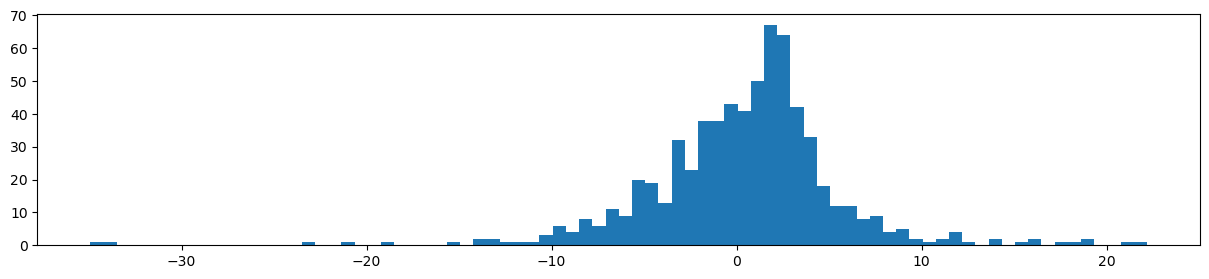

In [431]:
plt.figure(figsize=(15,3))
plt.hist(spread_percentages, bins=80)
plt.show()

In [432]:
pd.Series(open_num_trades).value_counts().sort_index(ascending=False)

6.0      5
5.0      5
4.0     12
3.0     42
2.0    128
1.0    222
0.0    259
dtype: int64

In [433]:
pd.Series(spread_percentages).describe()

count    672.000000
mean       0.341220
std        5.276642
min      -34.930000
25%       -2.072500
50%        0.930000
75%        2.817500
max       22.190000
dtype: float64

In [434]:
spy_per_rates = (prices_with_market[window_size_in_days:window_size_in_days+num_days_to_run]['SPY'].pct_change()*100).cumsum().dropna()
spy_per_rates = spy_per_rates.to_frame()
spy_per_rates

,SPY
date,
2000-02-04,-0.414598
2000-02-07,-0.568029
2000-02-08,0.792821
2000-02-09,-1.307634
2000-02-10,-1.108596
...,...
2019-12-11,151.074858
2019-12-12,151.936786
2019-12-13,151.996706


In [435]:
trade_returns = pd.DataFrame({'Date':trade_close_dates, 'Return': spread_percentages})
trade_returns['Return'] = trade_returns['Return']/number_trades_allowed

# Calculate the number of trades per Date
trade_counts = trade_returns.groupby('Date').size().rename('Trade_Count')

return_df = trade_returns.groupby('Date').sum()
return_df = return_df.cumsum()

# Add the trade counts to return_df
return_df = return_df.merge(trade_counts, on='Date', how='left')

return_df

,Return,Trade_Count
Date,,
2000-04-28,0.944667,2
2000-05-04,1.538000,1
2000-05-30,2.581333,1
2000-05-31,2.351333,2
2000-06-21,2.742667,1
...,...,...
2019-09-30,15.150000,3
2019-11-14,15.491333,1
2019-11-29,15.049333,1


In [436]:
merged_df = return_df.combine_first(spy_per_rates)
filled_df = merged_df.ffill()
filled_df

,Return,SPY,Trade_Count
2000-02-04,NaN,-0.414598,NaN
2000-02-07,NaN,-0.568029,NaN
2000-02-08,NaN,0.792821,NaN
2000-02-09,NaN,-1.307634,NaN
2000-02-10,NaN,-1.108596,NaN
...,...,...,...
2019-12-11,15.176667,151.074858,1.0
2019-12-12,15.176667,151.936786,1.0
2019-12-13,15.286667,151.996706,1.0
2019-12-16,15.286667,152.683707,1.0


In [437]:
merged_df.Return.isnull().sum()

4561

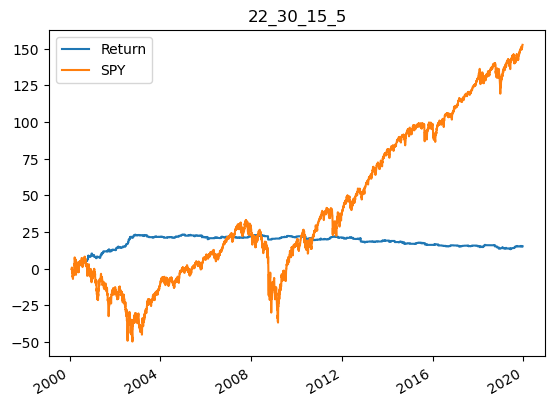

In [438]:
name = str(window_size_in_days) + '_' + str(num_liquid_stocks_to_consider) + '_' + str(number_trades_allowed) + '_' + str(num_clusters)

filled_df[['Return', 'SPY']].plot()
plt.title(name)
plt.show()

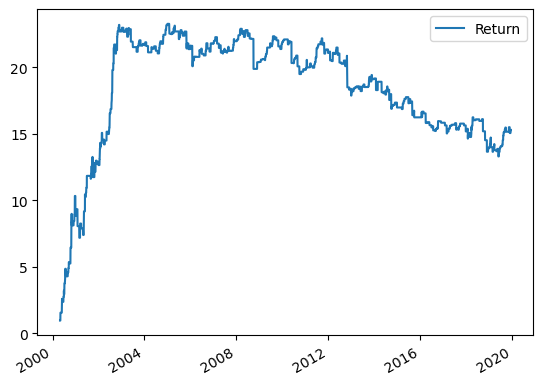

In [439]:
filled_df[['Return']].plot()
plt.show()

In [328]:
from itertools import zip_longest

# List to hold the rows for the dataframe
data = []

# Loop over each pair in the dictionary
for pair, trade_data in results.items():
    trade_info = trade_data['trade_info']
    open_trades = trade_info['open_trade_dates']
    close_trades = trade_info['close_trade_dates']
    
    # Use zip_longest to handle cases where lists have different lengths
    for open_trade, close_trade in zip_longest(open_trades, close_trades, fillvalue=(None, None, None, None)):
        # Unpack the open and close trades, using None as the default for missing close trades
        open_date, direction, open_price, investment, beta = open_trade if open_trade else (None, None, None, None, None)
        close_date, closing_reason, close_price, pct_profit = close_trade if close_trade else (None, None, None, None)
        
        # Add the combined data into the list
        data.append([
            pair, open_date, direction, open_price, close_date, closing_reason, 
            close_price, investment, beta, pct_profit
        ])

# Create a dataframe from the list of rows
columns = ['pair', 'open_date', 'direction', 'open_price', 'close_date', 'closing_reason', 'close_price', 'investment', 'beta', 'pct_profit']
df = pd.DataFrame(data, columns=columns)


In [329]:
num_neg_trades = len(df[df['pct_profit'] < 0])
num_pos_trades = len(df[df['pct_profit'] > 0])
print(num_neg_trades, 'num_neg_trades')
print(num_pos_trades, 'num_pos_trades')

89 num_neg_trades
123 num_pos_trades


In [330]:
df['direction'].value_counts()

Buying spread     109
Selling spread    105
Name: direction, dtype: int64

In [331]:
df['closing_reason'].value_counts()

Stocks are no longer cointegrated    129
Stocks mean reverted                  83
Name: closing_reason, dtype: int64

In [332]:
neg_df = df[(df['closing_reason'] == 'Stocks are no longer cointegrated') & (df['pct_profit'] < 0)]
print(neg_df.shape, 'neg_df')
pos_df = df[(df['closing_reason'] == 'Stocks are no longer cointegrated') & (df['pct_profit'] > 0)]
print(pos_df.shape, 'pos_df')

(89, 10) neg_df
(40, 10) pos_df


In [333]:
df_filtered = df[(df['closing_reason'] == 'Stocks are no longer cointegrated') & (df['pct_profit'] < 0)]
pair_count = df_filtered.groupby('pair').size().reset_index(name='count')
pair_count.head(110)

,pair,count
0,"(AMAT, CIEN)",1
1,"(AMAT, EMC1)",1
2,"(AMGN, AMZN)",1
3,"(AMGN, ORCL)",1
4,"(AMGN, QLGC)",1
...,...,...
83,"(VRTS1, PMCS)",1
84,"(VRTS1, YHOO)",1
85,"(WYE, MMM)",1
86,"(WYE, QLGC)",1


In [343]:
selected_pair = ('XOM', 'AMAT')
trades = df[df['pair']==selected_pair]
trades

,pair,open_date,direction,open_price,close_date,closing_reason,close_price,investment,beta,pct_profit
162,"(XOM, AMAT)",2002-10-31,Buying spread,8.68184,2002-11-29,Stocks are no longer cointegrated,8.26798,25.08616,0.74,-1.65


/var/folders/df/t690wl_95dg61prvkr2c5pbc0000gp/T/ipykernel_9530/3525087885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['open_date'] = pd.to_datetime(trades['open_date'])
/var/folders/df/t690wl_95dg61prvkr2c5pbc0000gp/T/ipykernel_9530/3525087885.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['close_date'] = pd.to_datetime(trades['close_date'])


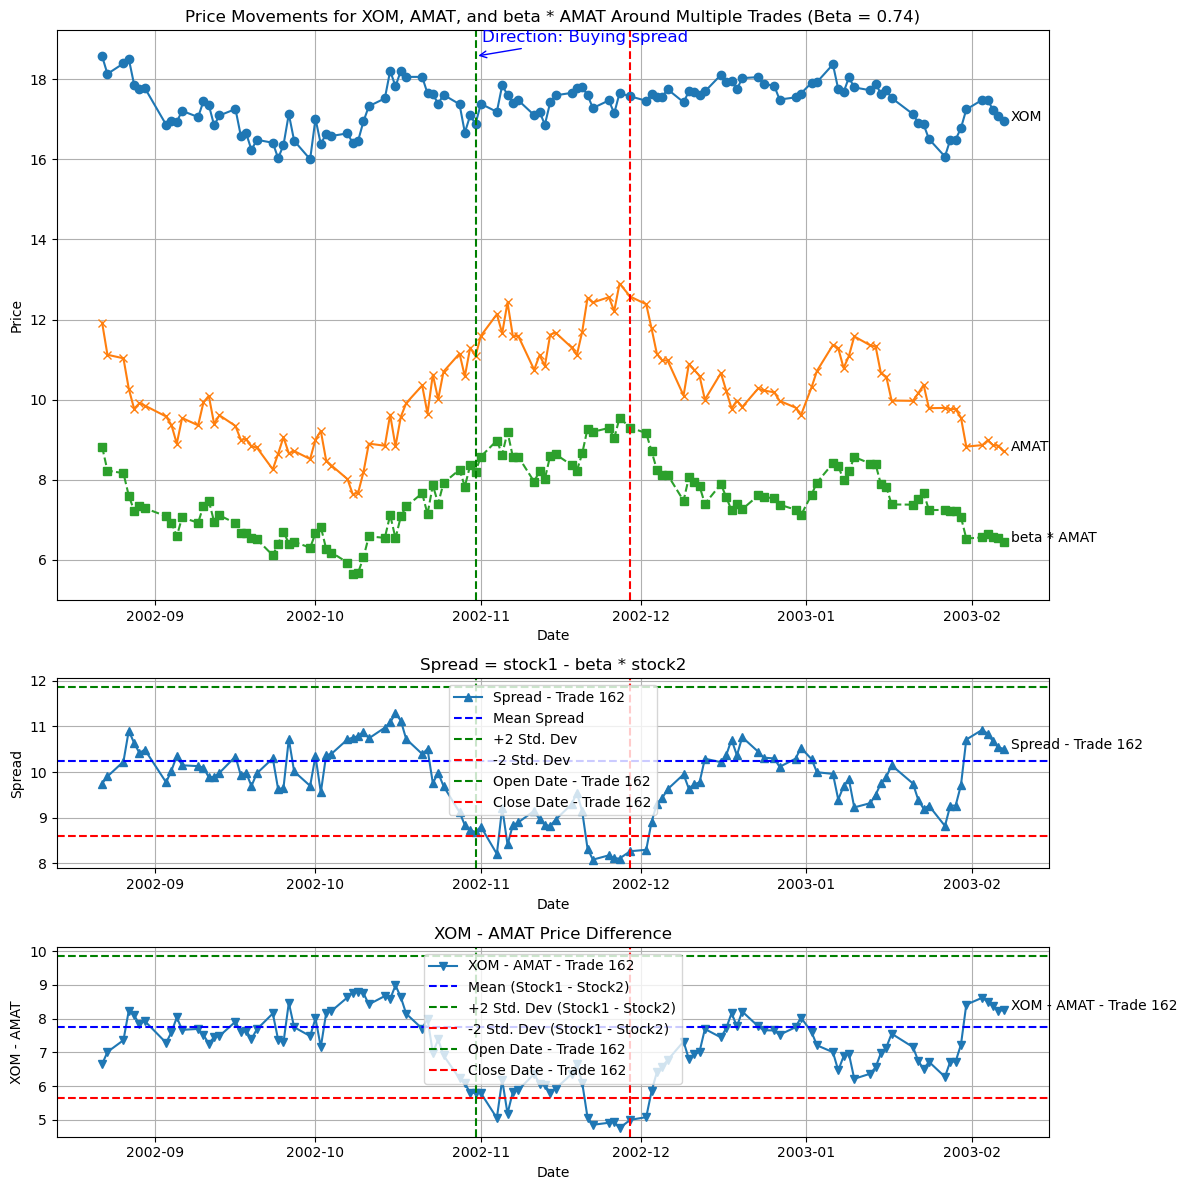

In [344]:
# Convert open_date and close_date columns to datetime if not already in that format
trades['open_date'] = pd.to_datetime(trades['open_date'])
trades['close_date'] = pd.to_datetime(trades['close_date'])

num_weeks = 10

# Extract the stock tickers from the selected pair
stock1, stock2 = selected_pair

# Initialize the subplots: 3 rows, 1 column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 1, 1]})

# Loop through each trade and plot the price data for stock1, stock2, and beta*stock2
for i, trade in trades.iterrows():
    open_date = trade['open_date']
    close_date = trade['close_date']
    beta = trade['beta']
    direction = trade['direction']  # Get the trade direction
    
    # Define the start and end dates (1 week before open and 1 week after close)
    start_date = open_date - pd.Timedelta(weeks=num_weeks)
    end_date = close_date + pd.Timedelta(weeks=num_weeks)
    
    # Assuming prices_with_market is a dataframe with date as index and stock1, stock2 as columns
    # Filter the price data between the start and end date for both stocks in the pair
    prices_filtered = prices_with_market.loc[start_date:end_date, [stock1, stock2]]
    
    # Calculate beta*stock2 and the spread = stock1 - beta * stock2
    beta_stock2 = beta * prices_filtered[stock2]
    spread = prices_filtered[stock1] - beta_stock2
    
    # Calculate stock1 - stock2 for the third subplot (ax3)
    stock1_minus_stock2 = prices_filtered[stock1] - prices_filtered[stock2]
    
    # Calculate mean and standard deviation of the spread over the 500 points before the trade opens
    prices_before_open = prices_with_market.loc[:open_date, [stock1, stock2]].tail(ndays_for_mean)
    beta_stock2_before_open = beta * prices_before_open[stock2]
    spread_before_open = prices_before_open[stock1] - beta_stock2_before_open
    mean_spread = spread_before_open.mean()
    std_spread = spread_before_open.std()
    
    # Calculate mean and standard deviation for stock1 - stock2
    stock1_minus_stock2_before_open = prices_before_open[stock1] - prices_before_open[stock2]
    mean_stock1_minus_stock2 = stock1_minus_stock2_before_open.mean()
    std_stock1_minus_stock2 = stock1_minus_stock2_before_open.std()
    
    # Calculate upper and lower bounds: mean ± 2 * standard deviation
    upper_bound_spread = mean_spread + 2 * std_spread
    lower_bound_spread = mean_spread - 2 * std_spread
    
    upper_bound_stock1_minus_stock2 = mean_stock1_minus_stock2 + 2 * std_stock1_minus_stock2
    lower_bound_stock1_minus_stock2 = mean_stock1_minus_stock2 - 2 * std_stock1_minus_stock2
    
    # Plot stock1, stock2, and beta*stock2 in the first subplot (ax1)
    ax1.plot(prices_filtered.index, prices_filtered[stock1], label=f'{stock1} - Trade {i}', linestyle='-', marker='o')
    ax1.plot(prices_filtered.index, prices_filtered[stock2], label=f'{stock2} - Trade {i}', linestyle='-', marker='x')  # Plot stock2
    ax1.plot(prices_filtered.index, beta_stock2, label=f'beta * {stock2} - Trade {i}', linestyle='--', marker='s')
    
    # Annotate lines directly on the plot
    ax1.annotate(f'{stock1}', xy=(prices_filtered.index[-1], prices_filtered[stock1].iloc[-1]), 
                 xytext=(5, 0), textcoords='offset points', color='black', fontsize=10)
    ax1.annotate(f'{stock2}', xy=(prices_filtered.index[-1], prices_filtered[stock2].iloc[-1]), 
                 xytext=(5, 0), textcoords='offset points', color='black', fontsize=10)
    ax1.annotate(f'beta * {stock2}', xy=(prices_filtered.index[-1], beta_stock2.iloc[-1]), 
                 xytext=(5, 0), textcoords='offset points', color='black', fontsize=10)
    
    # Highlight the open and close dates for each trade
    ax1.axvline(open_date, color='green', linestyle='--', label=f'Open Date - Trade {i}')
    ax1.axvline(close_date, color='red', linestyle='--', label=f'Close Date - Trade {i}')
    
    # Annotate the direction of the trade on the open date
    ax1.annotate(f'Direction: {direction}', xy=(open_date, prices_filtered[stock1].iloc[0]), 
                 xytext=(5, 10), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='blue'), fontsize=12, color='blue')
    
    # Plot the spread (stock1 - beta * stock2) in the second subplot (ax2)
    ax2.plot(prices_filtered.index, spread, label=f'Spread - Trade {i}', linestyle='-', marker='^')
    
    # Plot the mean and ±2 standard deviations for the spread
    ax2.axhline(mean_spread, color='blue', linestyle='--', label='Mean Spread')
    ax2.axhline(upper_bound_spread, color='green', linestyle='--', label='+2 Std. Dev')
    ax2.axhline(lower_bound_spread, color='red', linestyle='--', label='-2 Std. Dev')
    
    # Annotate spread line directly on the plot
    ax2.annotate(f'Spread - Trade {i}', xy=(prices_filtered.index[-1], spread.iloc[-1]), 
                 xytext=(5, 0), textcoords='offset points', color='black', fontsize=10)
    
    # Highlight the open and close dates in the second subplot
    ax2.axvline(open_date, color='green', linestyle='--', label=f'Open Date - Trade {i}')
    ax2.axvline(close_date, color='red', linestyle='--', label=f'Close Date - Trade {i}')
    
    # Plot stock1 - stock2 in the third subplot (ax3)
    ax3.plot(prices_filtered.index, stock1_minus_stock2, label=f'{stock1} - {stock2} - Trade {i}', linestyle='-', marker='v')
    
    # Plot the mean and ±2 standard deviations for stock1 - stock2
    ax3.axhline(mean_stock1_minus_stock2, color='blue', linestyle='--', label='Mean (Stock1 - Stock2)')
    ax3.axhline(upper_bound_stock1_minus_stock2, color='green', linestyle='--', label='+2 Std. Dev (Stock1 - Stock2)')
    ax3.axhline(lower_bound_stock1_minus_stock2, color='red', linestyle='--', label='-2 Std. Dev (Stock1 - Stock2)')
    
    # Annotate stock1 - stock2 line directly on the plot
    ax3.annotate(f'{stock1} - {stock2} - Trade {i}', xy=(prices_filtered.index[-1], stock1_minus_stock2.iloc[-1]), 
                 xytext=(5, 0), textcoords='offset points', color='black', fontsize=10)
    
    # Highlight the open and close dates in the third subplot
    ax3.axvline(open_date, color='green', linestyle='--', label=f'Open Date - Trade {i}')
    ax3.axvline(close_date, color='red', linestyle='--', label=f'Close Date - Trade {i}')

# Set titles and labels for the first plot with beta in the title
ax1.set_title(f"Price Movements for {stock1}, {stock2}, and beta * {stock2} Around Multiple Trades (Beta = {beta})")
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True)

# Set titles and labels for the second plot (spread)
ax2.set_title('Spread = stock1 - beta * stock2')
ax2.set_xlabel('Date')
ax2.set_ylabel('Spread')
ax2.legend()  # Add legend for mean and std dev
ax2.grid(True)

# Set titles and labels for the third plot (stock1 - stock2)
ax3.set_title(f'{stock1} - {stock2} Price Difference')
ax3.set_xlabel('Date')
ax3.set_ylabel(f'{stock1} - {stock2}')
ax3.legend()  # Add legend for mean and std dev
ax3.grid(True)

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

In [120]:
sp_mean  = np.mean(prices_with_market[:'2014-06-09'][-500:][selected_pair[0]] - beta*prices_with_market[:'2014-06-09'][-500:][selected_pair[1]])
sp_std = np.std(prices_with_market[:'2014-06-09'][-500:][selected_pair[0]] - beta*prices_with_market[:'2014-06-09'][-500:][selected_pair[1]])

sp_mean

-4.61529794

In [125]:
np.cov(prices_with_market[:'2014-06-09'][-500:][selected_pair[0]] , prices_with_market[:'2014-06-09'][-500:][selected_pair[1]])[0,1]/np.var(prices_with_market[:'2014-06-09'][-500:][selected_pair[1]])

0.7330032282613287

In [136]:
prices_with_market.loc['2014-06-27', selected_pair[0]] - beta*prices_with_market.loc['2014-06-27', selected_pair[1]]

-7.047560000000004

In [110]:
results[selected_pair]

{'is_cointegrated': False,
 'should_monitor': False,
 'trade_status_message': 'Stocks no longer cointegrated',
 'monitoring_start_dates': ['2014-06-09'],
 'monitoring_end_dates': ['2014-06-27'],
 'trade_info': {'open_trade_dates': [('2014-06-09',
    'Buying spread',
    -3.3164899999999946,
    75.39649,
    0.73)],
  'close_trade_dates': [('2014-06-27',
    'Stocks are no longer cointegrated',
    -7.047560000000004,
    -4.95)]},
 'trade_day_spread_position': 'unknown',
 'current_hedge_ratio': None,
 'current_spread_mean': None,
 'spread_upper_limit': 34.02818104546403,
 'spread_lower_limit': 12.622466699046948,
 'currently_trading': False}

# Visualization

# Investigating ETF's

In [6]:
import pandas as pd
import numpy as np

In [8]:
#ETF Paths
Paths_Dict = {
    'ETF_Prices.csv': "/Users/tuckeringlefield/Desktop/EFT_Data/ETF_prices.csv", 
    'ETFs.csv': "/Users/tuckeringlefield/Desktop/EFT_Data/ETFs.csv", 
    'MutualFund_Prices(AE).csv': "/Users/tuckeringlefield/Desktop/EFT_Data/MutualFund_Prices(AE).csv", 
    'MutualFund_Prices(FK).csv': "/Users/tuckeringlefield/Desktop/EFT_Data/MutualFund_Prices(FK).csv",
    'MutualFund_Prices(LP).csv': "/Users/tuckeringlefield/Desktop/EFT_Data/MutualFund_Prices(LP).csv",
    'MutualFund_Prices(QZ).csv': "/Users/tuckeringlefield/Desktop/EFT_Data/MutualFund_Prices(QZ).csv",
    'MutualFunds.csv': "/Users/tuckeringlefield/Desktop/EFT_Data/MutualFunds.csv", 
}
# Inspecting
for file in Paths_Dict.keys():
    print(f'Filename: {file}')
    print(pd.read_csv(Paths_Dict[file]).head())
    print()

Filename: ETF_Prices.csv
  fund_symbol  price_date   open   high    low  close  adj_close  volume
0         AAA  2020-09-09  25.10  25.12  25.07  25.07      24.85   17300
1         AAA  2020-09-10  25.06  25.07  25.05  25.07      24.85   23500
2         AAA  2020-09-11  25.04  25.05  25.02  25.03      24.81   33400
3         AAA  2020-09-14  25.01  25.06  25.01  25.02      24.80   13100
4         AAA  2020-09-15  25.02  25.03  25.01  25.01      24.79   12100

Filename: ETFs.csv
  fund_symbol quote_type region                  fund_short_name  \
0        AAAU        ETF     US  DWS RREEF Real Assets Fund - Cl   
1        AADR        ETF     US  AllianzGI Health Sciences Fund    
2        AAXJ        ETF     US                              NaN   
3        ABEQ        ETF     US  Thrivent Large Cap Growth Fund    
4        ACES        ETF     US                              NaN   

                                      fund_long_name currency  \
0               DWS RREEF Real Assets Fund 